# COGS 118B - Final Project

# for Personalized Dietary Needs

## Group members

- Youssef Franci
- Sid Joshi
- Jordan Nishi
- Michael Sherrick
- Yash Singh

# Abstract 
This project outlines the backend development for an innovative system designed to assist individuals with their personal dietary needs. With a focus on integrating advancements in object detection technology, nutritional analysis, and dietary guidance, our tool will be able to provide real-time support for individuals navigating their dietary challenges. Leveraging deep learning algorithms for character recognition and unsupervised learning techniques for item categorization, the proposed system will enable users to identify food items, understand important aspects of their nutritional content, and actively assess their compliance with specific dietary needs. In detailing characteristic food information to users, this system can facilitate healthier food choices, enhance dietary compliance, and ultimately improve the quality of life for its users.

# Background

In recent years, the intersection of technology and health has seen significant advancements, particularly in the development of tools for enhancing dietary management and nutritional awareness. The prevalence of dietary restrictions due to health conditions such as diabetes, cardiovascular diseases, and allergies, along with lifestyle choices such as vegetarianism, has necessitated the innovation of personalized dietary assistance technologies. This project builds upon a foundation of research and development in object detection, nutritional analysis, and dietary compliance technologies by offering an interpretable solution for individuals.

Significant progress has been made in the field of nutritional analysis, with studies exploring the use of image recognition and machine learning to estimate the nutritional content of foods from images, providing insights into calorie counts, macronutrient distributions, and micronutrient levels (Meyers et al., 20151)[]. This research is vital for our project, as it prompts relevant focus onto nutritional aspects of a large variety of foods.

Furthermore, the development of applications that cater to specific dietary restrictions has seen growing interest. For instance, systems have been designed to assist individuals with diabetes by tracking blood glucose levels and recommending appropriate foods[]. Similarly, apps targeting vegetarians and those with other dietary preferences have been developed to filter food choices based on set criteria[]. These are just a few of the many dietary guidance technologies that underscore the importance of our project's goal to integrate such functionalities into a comprehensive object detection and analysis system.

Our project synthesizes all of these aspects, creating the framework for a system that can provide real-time, focused information on food items simply from scanning its nutrition label. For instance, an individual with diabetes may aim for less than 10% of their total calories to be from saturated fats[5] and our model would be able to provide relevant information on sugar content about food items to guide their decision-making. By leveraging state-of-the-art object detection techniques and integrating unsupervised nutritional analysis algorithms, our system will provide relevant recommendations to support individuals in making informed dietary choices during their grocery shopping.


# Problem Statement

Individuals with dietary restrictions face the challenge of needing to carefully choose grocery items to cater to their needs. The process of deciding what is healthy or not can be difficult for impacted individuals or even for people that are shopping for these individuals. Nutritional information is complex with many interrelated nutrients to consider. Distilling this information into a digestible form would prove to be useful for impacted individuals or even for people that are shopping for these individuals. As shown in a study that tasked pharmacy students with purchasing foods for a diabetic individuals, the most difficult part of the activity was determining which foods are appropriate for a diabetic person and “look[ing] at the nutritional facts before considering buying it.”[6] In essence, how can we leverage unsupervised and deep learning methods to simplify the often-complex process of nutritional decision-making?


# Data

For this project, we used the following data on nutrition information as well as images of nutrition labels for a variety of foods:

1) Open Food Facts - https://world.openfoodfacts.org/datace.




To gain a better understanding of the different types of foods and their general nutrition values (e.g. protein, fat, sodium, sugar, calories), we decided to leverage a database from Open Food Facts, a non-profit organization dedicated to collecting and maintaining information on a variety of food products to help promote food transparency. Before filtering, the dataset contained 3,113,514 observations and 206 features, including metrics such as protein content, vitamin content, food group, additives, allergens, etc.

2) Nutrition Label Images gathered from Walmart

To supplement, 23 photos of nutrition fact labels from various grocery items are collected from Walmart’s shopping website. We chose a small sample to showcase the effectiveness of the product. Items from varying food groups were collected, including carbohydrates, red meat, poultry, dairy, vegetables, fruits, fish. Additionally, nutritional outliers such as maple syrup and Splenda are included due to their disproportionate nutritional content in one area. The data is representative of the different items found in grocery stores, including pantry essentials, snacks and produce.


## Data Preprocessing

Due to the high dimensionality of the dataset, it was cleaned as follows: Observations with 11 or more null values were excluded; features that were overly specific or did not pertain to the scope of this project’s main food groups (protein, sodium, fat, sugar, calories) were removed. After cleaning, the dataset stands at 9582 observations and 14 features. Variables include fat, cholesterol, carbohydrates, sugars, fibers, proteins, sodium, alcohol, potassium, calcium, iron, magnesium, zinc, and caffeine.

In [66]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# chunksize can be tuned depending on desired memory usage
# optional: nrows to stop reading after a certain number of rows have been read
pandas_reader = pd.read_csv("E:\\Food\\dset.csv", sep='\t', iterator=True, chunksize=10000, low_memory=False) 

In [4]:
with open("NeededCols2.txt", 'r') as file:
    needed_cols = [line.strip() for line in file.readlines()]

In [5]:
def mask_chunk(chunk, cols):
    # chunk - chunksize number of rows to process
    # cols - list of cols to filter out NaNs
    mask = np.logical_and(np.sum(~chunk[needed_cols].isnull().values, axis=-1) >= 11, ~chunk['serving_size'].isnull().values)
    return mask

In [6]:
def process_serving_size(raw_ss_string):
    compact_str = raw_ss_string.replace(' ', '')
    preceding = compact_str.split('g')[0][::-1]
    serving_size = ""
    for chr in preceding:
        if not chr.isdigit():
            break
        serving_size = "".join([serving_size, chr])
    try:
        serving_size = int(serving_size[::-1])
        return serving_size
    except:
        return 0

In [7]:
filtered_df = pd.concat([chunk[mask_chunk(chunk, needed_cols)] for chunk in pandas_reader])

C:\Users\micha\AppData\Local\Temp\ipykernel_27748\711359460.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  filtered_df = pd.concat([chunk[mask_chunk(chunk, needed_cols)] for chunk in pandas_reader])


In [8]:
filtered_df = filtered_df[needed_cols + ['product_name', 'serving_size']].fillna(0).copy()
filtered_df['serving_size'] = filtered_df['serving_size'].apply(process_serving_size)
filtered_df[needed_cols] = filtered_df[needed_cols].apply(lambda x: x * (filtered_df['serving_size'] / 100))
filtered_df = filtered_df[filtered_df['serving_size'] != 0]
filtered_df = filtered_df.drop('serving_size', axis=1).set_index('product_name')

In [9]:
from umap import UMAP
from sklearn.cluster import HDBSCAN

In [71]:
umap = UMAP(n_components=2, n_neighbors=100, min_dist=0.75, random_state=122)

In [72]:
ucs = umap.fit_transform(filtered_df)
ucs = pd.DataFrame(ucs, columns=['c1', 'c2'])
ucs.index = filtered_df.index

C:\Users\micha\AppData\Roaming\Python\Python39\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [77]:
hdbscan = HDBSCAN(min_cluster_size=100,
                  max_cluster_size=2500,
                  cluster_selection_epsilon=0.1,
                  n_jobs=-1)
fit_hdb = hdbscan.fit(ucs)

In [78]:
labels = fit_hdb.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
ucs['clustering'] = labels
ucs = ucs[ucs['clustering'] != -1]

# Proposed Solution
To help people determine characteristic information about a given food item, an unsupervised machine learning model will be developed that will allow users to upload a photo of a nutrition fact label and, based on their dietary needs, distill the information on the label into a brief description.
In the real world, this model would be integrated into a mobile device app that would allow for users to take photos of nutrition fact labels, but for the scope of this project, images from Walmart grocery items will be manually provided to the system.
The first step is to cluster nutrition label data in order to acquire a baseline understanding on how food is grouped to eventually inform users on the main characteristics of their food item. However, before proceeding with clustering, a UMAP algorithm is used to compress the dimensionality of the data, reducing it to a 2D structure while retaining the underlying relationships. We then employed HDBSCAN as our clustering method, provided by Sklearn, on the Open Food Facts data. Since the data are expected to have varying densities between clusters, HDBSCAN is preferred over DBSCAN. Hyperparameters that were assessed in fine-tuning include:


- UMAP
   - Min_dist - The minimum distance between points in low-dimensional space [0.1, 0.5, 0.75, 0.99]
   - N_neighbors - the number of nearest neighbors used to construct the topological representation [50, 100, 300, 500]
- HDBSCAN 
   - Min_cluster_size - minimum number of samples required to form a cluster [50, 100, 250, 500]
   - Cluster_selection_epsilon [0.01, 0.1, 0.5]

Secondly, image recognition is used to allow users to upload photos of nutrition fact labels. Pytesseract, the Python wrapper for Google’s Tesseract-OCR Engine, will be used to convert text found in images to editable text. Using Pytesseract’s `image_to_string` function, the text of the image is extracted. Within the extracted text, newlines and spaces are removed. Each time a % is encountered, the extracted text is split into a list. Additionally, a dictionary is initialized that contains keys for the prime nutrition metrics, including Calories, Total Fat, Saturated Fat, Trans Fat, Cholesterol, Sodium, Carbohydrates, Sugars, and Protein. Lastly, iterating through each element in this list, the code checks if any key in the dictionary is present. If so, the last three characters from the element, daily value, are placed into the corresponding key. In effect, the nutrition facts are converted into a format that can be analyzed.

Lastly, the system informs the user on the most notable nutritional content of their uploaded item. For example, the system would inform the user that a stick of butter is very high in fat content or that cookies are high in sugar. To achieve this, KNN with n = 11 will be utilized to assign the user’s uploaded item to one of the DBSCAN clusters. The UMAP data acts as the training set and the user’s photo acts as the test set. In effect, we avoid re-running UMAP. Based on the assigned cluster, the program will output which nutritional metric is most abundant in their uploaded item.


# Evaluation Metrics

To evaluate the performance of UMAP and HDBSCAN, sklearn’s Silhouette Scoring will be used. This metric is appropriate when performing unsupervised clustering without labels or number of clusters. Values closer to +1 indicate that data points are well matched with their cluster, 0 indicates that many points are on the decision boundary between clusters, and -1 indicates that points are most likely assigned to incorrect clusters. A silhouette score can be calculated by $$\text{silhouette}_i = \frac{b_i - a_i}{max(a_i,b_i)}$$

# Results
## Unsupervised Clustering
After performing a Grid Search, the best hyperparameters for UMAP and HDBSCAN were:

-UMAP

 -N_components - 2
 
 -N_neighbors = 100
 
 -Min_dist = 0.75
 
 -N_jobs = -1
 
-HDBSCAN

 -Min_cluster_size = 100
 
 -Max_cluster_size = 2500
 
 -Cluster_selection_epsilon = 0.1
 
 -N_jobs = -1

HDBSCAN clustering resulted in 11 clusters and were categorized by potassium, caffeine, carbohydrates, cholesterol and protein, sugar, fat, low on everything, alcohol, sodium, protein, cholesterol and low protein. Across five folds of the gridsearch, the resulting silhouette score was 0.43, indicating that the clusters are well-separated.

The resulting clusters are grouped on the relative proportion of a certain nutritional value compared to other items. For example, items in the potassium and caffeine clusters may have a similar amount of carbohydrates, relative to items in the carbohydrates cluster, their amount of carbohydrates are less than those in the carbohydrates cluster.

This information informs why the data was clustered in this way. In Cluster 0, potassium, these items all have similar nutritional values and high amounts of potassium. Similarly, Clusters 1, 2, 4, 5, 7, 8, and 9 contain items that are high in caffeine, carbs, sugar, fat, alcohol, sodium, and protein, respectively. Cluster 3 is unique in the fact that these items are all high in both cholesterol and protein, implying that there are many items that are high in both categories. Cluster 10 is similar to 3 except that it is high in cholesterol but low in protein. Lastly, Cluster 6 contains items that are low in every nutritional value which could be items such as artificial sugar sweetener.

## OCR Image Processing and Program Output

After testing on the 23 different food nutrition values from Walmart we found that OCR was not performing as consistently as we would like. Consequently, this requires further tuning to the OCR model or training a custom model for reading these labels.

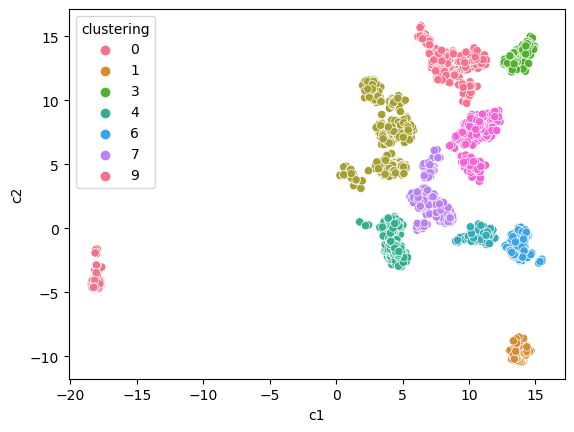

In [75]:
ax = sns.scatterplot(data=ucs[ucs['clustering'] != -1], x='c1', y='c2', hue='clustering', palette='husl')

In [42]:
d = {
    0: 'This food product has relatively high potassium amounts.',
    1: 'This food product has relatively high caffeine amounts.',
    2: 'This food product is relatively high in carbohydrates.',
    3: 'This food product has relatively high combined amounts of cholesterol and protein.',
    4: 'This food product is relatively high in sugar.',
    5: 'This food product has a relatively high fat content.',
    6: 'This food product has relatively low amounts of various nutrients.',
    7: 'This food product is best distinguished by its high alcohol content.',
    8: 'This food product has relatively high sodium content.',
    9: 'This food product is rich in protein.',
    10: 'This food product is relatively high in cholesterol, but on the lower end of protein content.'
}

In [43]:
def prep_dummy_data():

  data = { 'Total Fat': [0, 0, 3, 21, 13, 0, 12, 4, 0, 34, 15, 0, 0, 0, 13, 12, 6, 0, 0, 14, 1, 12, 2],
        'Cholesterol': [0, 0, 0, 27, 10, 0, 13, 0, 0, 27, 0, 0, 0, 0, 0, 8, 7, 0, 0, 0, 0, 10, 2],
        'Carb': [10, 2, 11, 0, 6, 14, 4, 7, 11, 0, 14, 10, 5, 4, 5, 1, 0, 0, 9, 7, 5, 4, 10],
        'Sugars': [0, 0, 24, 0, 0, 78, 0, 0, 20, 0, 1, 48, 0, 0, 0, 0, 0, 2, 40, 10, 1, 0, 28],
        'Fiber': [0, 11, 10, 0, 0, 0, 0, 54, 20, 0, 7, 0, 7, 11, 4, 0, 0, 0, 0, 7, 36, 0, 0],
        'Protein': [0, 6, 6, 38, 26, 0, 36, 10, 0, 38, 12, 0, 0, 4, 2, 12, 2, 0, 0, 10, 8, 16, 10],
        'Sodium': [2, 0, 9, 9, 22, 2, 19, 14, 0, 3, 50, 0, 0, 1, 6, 8, 1, 0, 0, 3, 5, 5, 4],
        'Alcohol': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Potassium': [6, 2, 4, 4, 8, 0, 6, 0, 5, 0, 4, 2, 0, 4, 6, 0, 0, 0, 0, 4, 2, 8, 6],
        'Calcium': [0, 2, 10, 0, 0, 0, 0, 6, 0, 0, 0, 2, 4, 0, 0, 15, 2, 0, 0, 4, 2, 20, 20],
        'Iron': [0, 6, 20, 0, 4, 0, 8, 4, 2, 4, 15, 0, 2, 4, 0, 0, 0, 0, 0, 6, 2, 0, 0],
        'Magnesium': [0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Zinc': [0, 0, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        'Caffeine': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        }

  nut_lab = pd.DataFrame(data = data)
  conv_nums = np.array([78.0, 0.03, 275.0, 50.0, 28.0, 50.0, 2.3, 1.0, 4.7, 1.3, 0.18, 0.42, 0.011, 1.0]) / 100

  for i, col in enumerate(nut_lab.columns):
    nut_lab[col] *= conv_nums[i]
  return nut_lab

In [46]:
def test_app(df, lab, umap, ucs):
  label = df.iloc[lab].to_numpy()

  # Transforming input array into UMAP space  
  print('Summarizing nutrition information...')

  mapped_pt = umap.transform(label[None, ...])

  # Creating KNN object
  knn = KNeighborsClassifier(n_neighbors = 11)

  knn.fit(ucs.iloc[:, :2], ucs.iloc[:, 2])

  # Find cluster assignment for input data
  assignment = knn.predict(mapped_pt)

  # Print summary statement of food based on cluster assignment
  print(d[assignment[0]])

In [60]:
# test with coca-cola (index 5 in dummy data)
test_app(prep_dummy_data(), 5, umap, ucs)

Summarizing nutrition information...
This food product is relatively high in sugar.


C:\Users\micha\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [79]:
# test with ramen (index 10 in dummy data)
test_app(prep_dummy_data(), 10, umap, ucs)

Summarizing nutrition information...
This food product has relatively high sodium content.


C:\Users\micha\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [65]:
def run_app(umap):

  # Get image from user
  print('Please upload an image of a nutrition label:')
  uploaded_image = files.upload()

  # Extract information from input label and convert to array
  print('Reading label...')
  ocr_output = ocr_to_dict(uploaded_image)

  ocr_arr = np.array([])
  for key in ocr_output:
    ocr_arr = np.append(ocr_arr, ocr_output[key])

  # Transforming input array into UMAP space  
  print('Summarizing nutrition information...')

  mapped_pt = umap.transform(ocr_arr[None, ...])

  # Creating KNN object
  knn = KNeighborsClassifier(n_neighbors = 11)

  knn.fit(umap.iloc[:, :2], umap[:, 2])

  # Find cluster assignment for input data
  assignment = knn.predict(ocr_arr)

  # Print summary statement of food based on cluster assignment
  print(d[assignment[0]])

# Discussion
## Interpreting Results

Overall, it seems that the clustering is able to separate a highly complex food based on one or two nutritional values. This is useful for the project’s purposes as it successfully simplifies complex nutritional information into defining characteristics of a given food. In observing this separation, we are able to confidently categorize new data into one of these clusters and provide users with data that distills nutrition information down to describe prime characteristics of the food.

# Discussion
## Interpreting Results

Overall, it seems that the clustering is able to separate a highly complex food based on one or two nutritional values. This is useful for the project’s purposes as it successfully simplifies complex nutritional information into defining characteristics of a given food. In observing this separation, we are able to confidently categorize new data into one of these clusters and provide users with data that distills nutrition information down to describe prime characteristics of the food.
ts users.


## Limitations
Some limitations to the project involve the efficacy of the OCR models. In many cases a photo’s lighting, angle, or complexity threw off the character recognition. As a result, the nutrition labels used in this project were taken from a digital format with very clear contours and numbers. Additionally, this project is only able to use one format of nutrition label. For example, some labels on the back of milk cartons display nutrition facts in a horizontal format, which the OCR model was not able to interpret. In the project, incompatible labels had their data manually inputted without OCR. For future resolution, finer tuning of the OCR must be done. If this does not solve the issue, the training of a specialized nutrition-label OCR model may be necessary.

Another issue is that the current program is not compatible with many fruit and vegetable items due to its reliance on nutrition labels. Besides bagged and frozen fruits and vegetables, there is no current way for users to determine if a particular produce item is a healthy choice.

Lastly, for future development, the system should be able to take in more customized dietary restrictions. Currently, it is only compatible with individuals with diabetes, high blood pressure, and high protein diets.


## Ethics and Privacy
To help users understand how the system makes its recommendations, we will provide users with clear explanations of how dietary recommendations are generated and why certain items are flagged as non-compliant with their dietary restrictions, and asking for explicit consent to do so in the beginning of the application’s first use. This overcomes the possible infringement of the autonomy of the user to classify the foods into categories for them. 

Additionally, there may be a concern that the categorisation of foods into healthy and unhealthy could lead to stigmatization of certain food groups, guilt associated with eating and increased disordered eating especially among those with a history of such conditions. To overcome this risk, we will be transparent and explain (as highlighted above) the purpose of the application, with the results personalized for the user based on the data they have provided. In the feedback system, we will explicitly include a link to the National Eating Disorders webpage[7], which includes the resources for help and the numbers for eating disorder helplines, along with a link to the crisis text line[8].

## Conclusion
Overall, with use of dimensionality reduction, unsupervised methods, and supervised methods, we are able to successfully distill a complex database of nutrition information down into a food item’s prime characteristics. Based on metrics such as silhouette score, we can confidently conclude that these different food items are distinctly categorized and that we are performing accurate analysis of user-submitted items. The system we developed will hopefully alleviate challenges faced while grocery shopping for special diets, such as for diabetic individuals as mentioned by Trujillo, J. M., & Hardy, Y. In the future, we hope to address limitations surrounding the systems’ real-world application such as the efficacy of our object character recognition (OCR) model and compatibility with more grocery options. As a long term goal, we imagine this system being implemented into a mobile app to facilitate healthier food choices, enhance dietary compliance, and ultimately improve the quality of life for its users.


# Footnotes

He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep Residual Learning for Image Recognition. Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 770-778.

Meyers, A., Johnston, N., Rathod, V., Huang, A., Korattikara, A., Gorban, A., Silberman, N., Guadarrama, S., & Papandreou, G. (2015). Im2Calories: Towards an Automated Mobile Vision Food Diary. Proceedings of the 2015 ACM on International Conference on Multimodal Interaction, 427-434.

Smith, J. D., Suto, M. J., & Lee, H. (2017). Mobile Application for Diabetes Control: A Systematic Review and Meta-Analysis. Diabetes Technology & Therapeutics, 19(1), 1-9.

Zhou, L., Bao, J., Setiawan, I. M. A., Saptono, A., & Parmanto, B. (2018). The mHealth App Usability Questionnaire (MAUQ): Development and Validation Study. JMIR mHealth and uHealth, 6(4), e148.

HealthLinkBC. Reading food labels when you have diabetes. https://www.healthlinkbc.ca/illnesses-conditions/diabetes/reading-food-labels-when-you-have-diabetes

Trujillo, J. M., & Hardy, Y. (2009). A Nutrition Journal and Diabetes Shopping Experience to Improve Pharmacy Students’ Empathy and Cultural Competence. American Journal of Pharmaceutical Education, 73(2), 37. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2690890/

Get Help. National Eating Disorders Association (NEDA). https://www.nationaleatingdisorders.org/get-help/.

Crisis Text Line. https://www.crisistextline.org/.